In [1]:
import pandas as pd
import numpy as np
import os
import glob
from pandas import DataFrame, read_csv
import matplotlib.pyplot as plt
import pandas as pd
import wfdb
import statsmodels.api as sm
import matplotlib.image as mpimg
import tkinter as tk
from matplotlib.figure import Figure
from IPython.display import display, HTML
import csv
from collections import defaultdict
from sklearn.metrics import r2_score
import matplotlib.ticker as ticker
import pickle
from sklearn.linear_model import LogisticRegression
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D,Conv1D, MaxPooling1D, BatchNormalization
from keras.utils import np_utils
from keras.initializers import RandomNormal
from keras import backend as Ks
from keras import optimizers
from keras.optimizers import SGD,adam
from keras.models import model_from_json
import matplotlib as mpl
import keras as ks
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import roc_curve, roc_auc_score

Using TensorFlow backend.


In [2]:
def getCNNModeltoInterpret(fname):
    learning_rate = 0.1
    momentum = 0.0
    model = ks.Sequential()
    # Conv Layer 1
    model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1, input_shape=(None,3),
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())

    # Conv Layer 2-11 (10 layers)
    for layernum in range(10):
        model.add(ks.layers.Conv1D(filters=10, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
        model.add(Activation('relu'))
        model.add(BatchNormalization())
    
    # Conv Layer 12
    model.add(ks.layers.Conv1D(filters=1, kernel_size=5, strides=1,
                           padding='same',use_bias=True, 
                           kernel_initializer='glorot_uniform', bias_initializer='zeros'))
    model.add(Activation('sigmoid'))
    previousModel = ks.models.load_model(fname)
    model.set_weights(previousModel.get_weights())
    return model

In [3]:
def getCNNSegMap(model, dfstat, data):
    TOTAL_LEN = np.shape(data)[0]

    mRR = dfstat['Mean'][dfstat['Parameter']=='RR'].values[0]
    sdRR = dfstat['StdDev'][dfstat['Parameter']=='RR'].values[0]
    mSpO2 = dfstat['Mean'][dfstat['Parameter']=='SpO2'].values[0]
    sdSpO2 = dfstat['StdDev'][dfstat['Parameter']=='SpO2'].values[0]
    mHR = dfstat['Mean'][dfstat['Parameter']=='HR'].values[0]
    sdHR = dfstat['StdDev'][dfstat['Parameter']=='HR'].values[0]

    rrnaf = (data['RRraw'].values - mRR)/sdRR
    spo2naf = (data['SpO2raw'].values - mSpO2)/sdSpO2
    hrnaf = (data['HRraw'].values - mHR)/sdHR
    
    X_TEST = np.zeros((1,TOTAL_LEN,3), dtype=np.float32)
    X_TEST[0,:,0] = rrnaf
    X_TEST[0,:,1] = spo2naf
    X_TEST[0,:,2] = hrnaf
    predictions = model.predict(X_TEST)
    return predictions[0,:,0]

In [4]:
def getPosProbSAX(refProbDf, dfstat, data):
    mRR = dfstat['Mean'][dfstat['Parameter']=='RR'].values[0]
    sdRR = dfstat['StdDev'][dfstat['Parameter']=='RR'].values[0]
    mSpO2 = dfstat['Mean'][dfstat['Parameter']=='SpO2'].values[0]
    sdSpO2 = dfstat['StdDev'][dfstat['Parameter']=='SpO2'].values[0]
    mHR = dfstat['Mean'][dfstat['Parameter']=='HR'].values[0]
    sdHR = dfstat['StdDev'][dfstat['Parameter']=='HR'].values[0]
    tdf = pd.DataFrame(columns=['RR','SpO2','HR','nRR','nSpO2','nHR','symRR','symSpO2','symHR','Symbol','Label'])
    tdf['RR'] = data['RRraw'].values
    tdf['SpO2'] = data['SpO2raw'].values
    tdf['HR'] = data['HRraw'].values
    tdf['nRR'] = (data['RRraw'].values - mRR)/sdRR
    tdf['nSpO2'] = (data['SpO2raw'].values - mSpO2)/sdSpO2
    tdf['nHR'] = (data['HRraw'].values - mHR)/sdHR
    tdf['Label'] = data['Label'].values
    cutpoints = [-np.inf,-1.5,-1,-0.5,0,0.5,1,1.5,np.inf]
    tdf['symRR'] = pd.cut(tdf['nRR'], bins = cutpoints, labels=["A","B","C","D","E","F","G","H"])
    tdf['symSpO2'] = pd.cut(tdf['nSpO2'], bins = cutpoints, labels=["A","B","C","D","E","F","G","H"])
    tdf['symHR'] = pd.cut(tdf['nHR'], bins = cutpoints, labels=["A","B","C","D","E","F","G","H"])
    tdf['Symbol'] = tdf.apply(lambda row: row['symRR']+ row['symSpO2']+row['symHR'],axis=1)
    newtdf = pd.merge(tdf , refProbDf[['Symbol', 'PosProb']], how = 'left', left_on='Symbol', right_on='Symbol')
    return newtdf['PosProb'].values

In [5]:
def movingAvg(x,n):
    y = np.zeros(len(x),dtype=np.float32)
    ysum = 0
    for i in range(len(x)):
        if(i<n):
            ysum += x[i]
            y[i] = ysum/float(i+1)
        else:
            ysum = ysum + x[i] - x[i-n]
            y[i] = ysum/float(n)
    return y

##### Get RMSE, area under ROC, area under PR for training data

In [18]:
def getMetrics(setName,y_true,y_prob,t):
    print('-------------------',setName,'--------------------------')
    X = len(y_true)
    T = sum(y_true)
    F = X-T
    print('Total points : ' + str(X))
    print('Positive points : ' + str(T))
    print('Negative points : ' + str(F))

    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    auc_roc = roc_auc_score(y_true, y_prob)
    
    precision, recall, thresholdsPR = precision_recall_curve(y_true, y_prob)
    aucPR = auc(recall, precision)

    print('AUC ROC:', auc_roc)
    print('AUC PR: ', aucPR)
    plt.plot(fpr,tpr)
    plt.title('ROC')
    plt.show()
    plt.plot(recall,precision)
    plt.title('Precision Recall')
    plt.show()
    

    dist_corner = (1-tpr)*(1-tpr) + fpr*fpr
    ind = np.argmin(dist_corner)
    print('Best threshold according to corner rule and its index: ',thresholds[ind],"   ",ind)
    sens = tpr[ind]
    spec = 1 - fpr[ind]
    print('Sensitivity: ', sens)
    print('Specificity : ', spec)

    print('ON  A PARTICULAR THRESHOLD')
    print('This threshold being ', t)
    dist = abs(t-thresholds)
    ind = list(dist).index(min(list(dist)))
    print('Best threshold based on point closest to t: ' + str(thresholds[ind]))
    sens = tpr[ind]
    spec = 1-fpr[ind]
    acc = (sens*T + spec*F)/X
    print('Sensitivity at threshold : ' + str(sens))
    print('Specificiy at threshold : ' + str(spec))
    print('Accuracy at threshold : ' + str(acc))

In [19]:
START = 0
END = 110
print('TRAINING SET')
refProbDf = pd.read_csv('SAXProb.csv')
dfstat = pd.read_csv(r'parStat.csv',sep=',')
TOTAL_ERROR_SAX = 0
TOTAL_PTS = 0
TOTAL_ERROR_CNN = 0
mylabel = []
mysax = []
mycnn = []
model = getCNNModeltoInterpret('SegCNN.h5')
for i in range(START,END,1):
    print(i,end=" ")
    fname = './SeriesSegData/p' + str(i).zfill(3) + '.csv'
    data = pd.read_csv(fname,sep=',')
    TOTAL_LEN = np.shape(data)[0]
    t = np.arange(0,TOTAL_LEN,1)
    x = t/60.0
    y = data['Label'].values
    SAXprob = getPosProbSAX(refProbDf, dfstat, data)
    CNNpred = getCNNSegMap(model, dfstat, data)
    avgSAXprob = movingAvg(SAXprob,120)
    avgCNNpred = movingAvg(CNNpred,120)
    mylabel = mylabel + list(y)
    mysax = mysax + list(avgSAXprob)
    mycnn = mycnn + list(avgCNNpred)
    error_sax = sum(np.square(avgSAXprob - y))
    error_cnn = sum(np.square(avgCNNpred - y))
    TOTAL_ERROR_SAX += error_sax
    TOTAL_ERROR_CNN += error_cnn
    TOTAL_PTS += TOTAL_LEN

TRAINING SET
0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 

Total points : 608722
Positive points : 175955
Negative points : 432767
SAX MSE : 0.2818721018378589
------------------- TRAINING SAX --------------------------
Total points : 608722
Positive points : 175955
Negative points : 432767
AUC ROC: 0.9618658553238848
AUC PR:  0.930626541362695


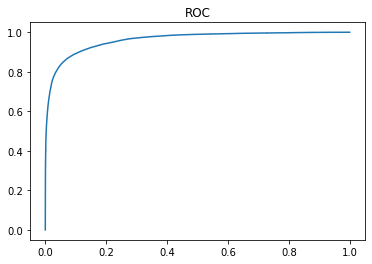

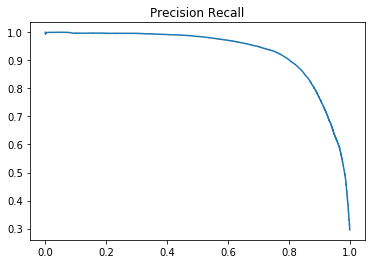

Best threshold according to corner rule and its index:  0.34207428     55468
Sensitivity:  0.8872268477735785
Specificity :  0.906732722226972
ON  A PARTICULAR THRESHOLD
This threshold being  0.35
Best threshold based on point closest to t: 0.35000664
Sensitivity at threshold : 0.8822937682930294
Specificiy at threshold : 0.9122460816097345
Accuracy at threshold : 0.9035881732547862
CNN MSE : 0.25033592159081536
------------------- TRAINING CNN --------------------------
Total points : 608722
Positive points : 175955
Negative points : 432767
AUC ROC: 0.9639050797284177
AUC PR:  0.9319519260187799


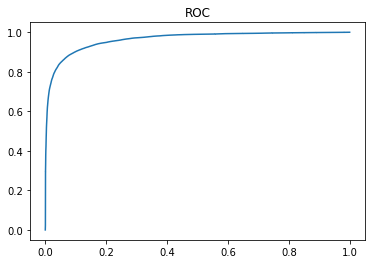

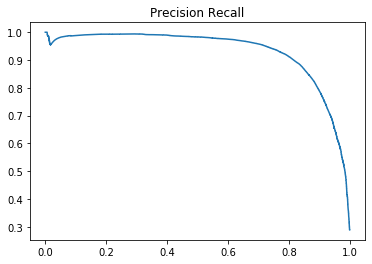

Best threshold according to corner rule and its index:  0.3107413     48483
Sensitivity:  0.8932681651558637
Specificity :  0.911079171933165
ON  A PARTICULAR THRESHOLD
This threshold being  0.3
Best threshold based on point closest to t: 0.2999987
Sensitivity at threshold : 0.8971498394475861
Specificiy at threshold : 0.9062151226872659
Accuracy at threshold : 0.9035947443989211


In [20]:
X = len(mylabel)
T = sum(mylabel)
F = len(mylabel)-sum(mylabel)
print('Total points : ' + str(X))
print('Positive points : ' + str(T))
print('Negative points : ' + str(F))

t = 0.35
print('SAX MSE :', np.sqrt(TOTAL_ERROR_SAX/TOTAL_PTS))
y_true = mylabel
y_prob_sax = mysax
getMetrics('TRAINING SAX',y_true,y_prob_sax,t)

t = 0.30
print('CNN MSE :', np.sqrt(TOTAL_ERROR_CNN/TOTAL_PTS))
y_prob_cnn = mycnn
getMetrics('TRAINING CNN',y_true,y_prob_cnn,t)


In [21]:
START = 110
END = 140
print('VALIDATION SET')
refProbDf = pd.read_csv('SAXProb.csv')
dfstat = pd.read_csv(r'parStat.csv',sep=',')
TOTAL_ERROR_SAX = 0
TOTAL_PTS = 0
TOTAL_ERROR_CNN = 0
mylabel = []
mysax = []
mycnn = []
model = getCNNModeltoInterpret('SegCNN.h5')
for i in range(START,END,1):
    print(i,end=" ")
    fname = './SeriesSegData/p' + str(i).zfill(3) + '.csv'
    data = pd.read_csv(fname,sep=',')
    TOTAL_LEN = np.shape(data)[0]
    t = np.arange(0,TOTAL_LEN,1)
    x = t/60.0
    y = data['Label'].values
    SAXprob = getPosProbSAX(refProbDf, dfstat, data)
    CNNpred = getCNNSegMap(model, dfstat, data)
    avgSAXprob = movingAvg(SAXprob,120)
    avgCNNpred = movingAvg(CNNpred,120)
    mylabel = mylabel + list(y)
    mysax = mysax + list(avgSAXprob)
    mycnn = mycnn + list(avgCNNpred)
    error_sax = sum(np.square(avgSAXprob - y))
    error_cnn = sum(np.square(avgCNNpred - y))
    TOTAL_ERROR_SAX += error_sax
    TOTAL_ERROR_CNN += error_cnn
    TOTAL_PTS += TOTAL_LEN

VALIDATION SET
110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 

Total points : 160105
Positive points : 20520
Negative points : 139585
SAX MSE : 0.2798702877652315
------------------- VALIDATION SAX --------------------------
Total points : 160105
Positive points : 20520
Negative points : 139585
AUC ROC: 0.8758101699545038
AUC PR:  0.6977575693472164


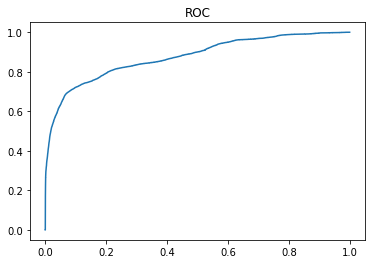

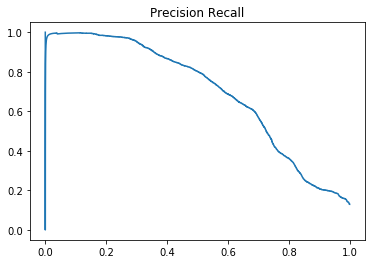

Best threshold according to corner rule and its index:  0.25484183     14467
Sensitivity:  0.7984892787524367
Specificity :  0.795135580470681
ON  A PARTICULAR THRESHOLD
This threshold being  0.35
Best threshold based on point closest to t: 0.35005912
Sensitivity at threshold : 0.7220272904483431
Specificiy at threshold : 0.8992226958484077
Accuracy at threshold : 0.8765122888104682
CNN MSE : 0.2643161690646088
------------------- VALIDATION CNN --------------------------
Total points : 160105
Positive points : 20520
Negative points : 139585
AUC ROC: 0.8851279900926033
AUC PR:  0.692131132229615


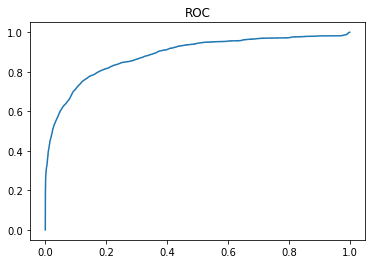

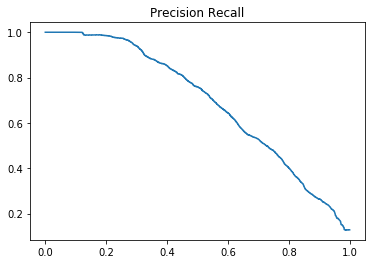

Best threshold according to corner rule and its index:  0.21478097     12911
Sensitivity:  0.7976608187134503
Specificity :  0.8284199591646667
ON  A PARTICULAR THRESHOLD
This threshold being  0.3
Best threshold based on point closest to t: 0.30000326
Sensitivity at threshold : 0.73864522417154
Specificiy at threshold : 0.8854246516459505
Accuracy at threshold : 0.8666125355235627


In [22]:
X = len(mylabel)
T = sum(mylabel)
F = len(mylabel)-sum(mylabel)
print('Total points : ' + str(X))
print('Positive points : ' + str(T))
print('Negative points : ' + str(F))

t = 0.35
print('SAX MSE :', np.sqrt(TOTAL_ERROR_SAX/TOTAL_PTS))
y_true = mylabel
y_prob_sax = mysax
getMetrics('VALIDATION SAX',y_true,y_prob_sax,t)

t = 0.30
print('CNN MSE :', np.sqrt(TOTAL_ERROR_CNN/TOTAL_PTS))
y_prob_cnn = mycnn
getMetrics('VALIDATION CNN',y_true,y_prob_cnn,t)


In [23]:
START = 140
END = 180
print('TEST SET')
refProbDf = pd.read_csv('SAXProb.csv')
dfstat = pd.read_csv(r'parStat.csv',sep=',')
TOTAL_ERROR_SAX = 0
TOTAL_PTS = 0
TOTAL_ERROR_CNN = 0
mylabel = []
mysax = []
mycnn = []
model = getCNNModeltoInterpret('SegCNN.h5')
for i in range(START,END,1):
    print(i,end=" ")
    fname = './SeriesSegData/p' + str(i).zfill(3) + '.csv'
    data = pd.read_csv(fname,sep=',')
    TOTAL_LEN = np.shape(data)[0]
    t = np.arange(0,TOTAL_LEN,1)
    x = t/60.0
    y = data['Label'].values
    SAXprob = getPosProbSAX(refProbDf, dfstat, data)
    CNNpred = getCNNSegMap(model, dfstat, data)
    avgSAXprob = movingAvg(SAXprob,120)
    avgCNNpred = movingAvg(CNNpred,120)
    mylabel = mylabel + list(y)
    mysax = mysax + list(avgSAXprob)
    mycnn = mycnn + list(avgCNNpred)
    error_sax = sum(np.square(avgSAXprob - y))
    error_cnn = sum(np.square(avgCNNpred - y))
    TOTAL_ERROR_SAX += error_sax
    TOTAL_ERROR_CNN += error_cnn
    TOTAL_PTS += TOTAL_LEN

TEST SET
140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 

Total points : 232232
Positive points : 64718
Negative points : 167514
SAX MSE : 0.3052445798521349
------------------- TEST SAX --------------------------
Total points : 232232
Positive points : 64718
Negative points : 167514
AUC ROC: 0.9466834494421739
AUC PR:  0.8952023144641862


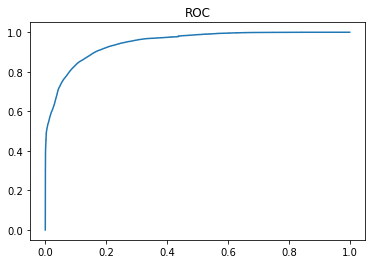

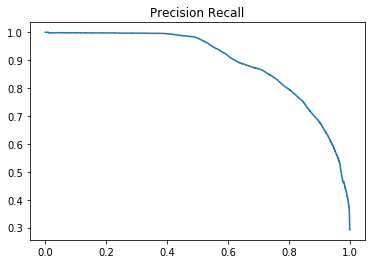

Best threshold according to corner rule and its index:  0.35007435     25991
Sensitivity:  0.867702957446151
Specificity :  0.8700825005671168
ON  A PARTICULAR THRESHOLD
This threshold being  0.35
Best threshold based on point closest to t: 0.35000044
Sensitivity at threshold : 0.8677647640532773
Specificiy at threshold : 0.8700048951132443
Accuracy at threshold : 0.8693806193806194
CNN MSE : 0.2875860389577863
------------------- TEST CNN --------------------------
Total points : 232232
Positive points : 64718
Negative points : 167514
AUC ROC: 0.945550980408975
AUC PR:  0.8897484222251326


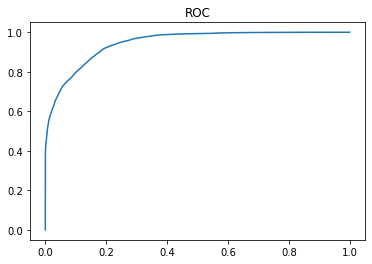

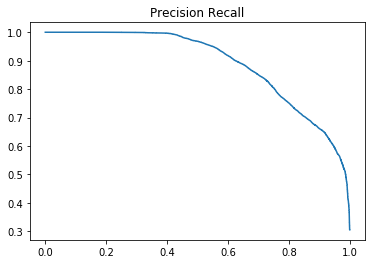

Best threshold according to corner rule and its index:  0.26638857     26660
Sensitivity:  0.8713031923112581
Specificity :  0.8473321632818749
ON  A PARTICULAR THRESHOLD
This threshold being  0.3
Best threshold based on point closest to t: 0.30000317
Sensitivity at threshold : 0.8402917271856362
Specificiy at threshold : 0.8691333261697529
Accuracy at threshold : 0.8610958007509731


In [24]:
X = len(mylabel)
T = sum(mylabel)
F = len(mylabel)-sum(mylabel)
print('Total points : ' + str(X))
print('Positive points : ' + str(T))
print('Negative points : ' + str(F))

t = 0.35
print('SAX MSE :', np.sqrt(TOTAL_ERROR_SAX/TOTAL_PTS))
y_true = mylabel
y_prob_sax = mysax
getMetrics('TEST SAX',y_true,y_prob_sax,t)

t = 0.30
print('CNN MSE :', np.sqrt(TOTAL_ERROR_CNN/TOTAL_PTS))
y_prob_cnn = mycnn
getMetrics('TEST CNN',y_true,y_prob_cnn,t)
